# Customer Segmentation using Clustering
***
This mini-project is based on [this blog post](http://blog.yhat.com/posts/customer-segmentation-using-python.html) by yhat. Please feel free to refer to the post for additional information, and solutions.

In [1]:
%matplotlib inline
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Setup Seaborn
sns.set_style("whitegrid")
sns.set_context("poster")

## Data

The dataset contains information on marketing newsletters/e-mail campaigns (e-mail offers sent to customers) and transaction level data from customers. The transactional data shows which offer customers responded to, and what the customer ended up buying. The data is presented as an Excel workbook containing two worksheets. Each worksheet contains a different dataset.

In [2]:
df_offers = pd.read_excel("./WineKMC.xlsx", sheetname=0)
df_offers.columns = ["offer_id", "campaign", "varietal", "min_qty", "discount", "origin", "past_peak"]
df_offers.head()

/anaconda3/lib/python3.6/site-packages/pandas/io/excel.py:329: FutureWarning: The `sheetname` keyword is deprecated, use `sheet_name` instead
  **kwds)


,offer_id,campaign,varietal,min_qty,discount,origin,past_peak
0,1,January,Malbec,72,56,France,False
1,2,January,Pinot Noir,72,17,France,False
2,3,February,Espumante,144,32,Oregon,True
3,4,February,Champagne,72,48,France,True
4,5,February,Cabernet Sauvignon,144,44,New Zealand,True


We see that the first dataset contains information about each offer such as the month it is in effect and several attributes about the wine that the offer refers to: the variety, minimum quantity, discount, country of origin and whether or not it is past peak. The second dataset in the second worksheet contains transactional data -- which offer each customer responded to.

In [3]:
df_transactions = pd.read_excel("./WineKMC.xlsx", sheetname=1)
df_transactions.columns = ["customer_name", "offer_id"]
df_transactions['n'] = 1
df_transactions.head()

/anaconda3/lib/python3.6/site-packages/pandas/io/excel.py:329: FutureWarning: The `sheetname` keyword is deprecated, use `sheet_name` instead
  **kwds)


,customer_name,offer_id,n
0,Smith,2,1
1,Smith,24,1
2,Johnson,17,1
3,Johnson,24,1
4,Johnson,26,1


## Data wrangling

We're trying to learn more about how our customers behave, so we can use their behavior (whether or not they purchased something based on an offer) as a way to group similar minded customers together. We can then study those groups to look for patterns and trends which can help us formulate future offers.

The first thing we need is a way to compare customers. To do this, we're going to create a matrix that contains each customer and a 0/1 indicator for whether or not they responded to a given offer. 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set I</h3>

<p><b>Exercise:</b> Create a data frame where each row has the following columns (Use the pandas [`merge`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.merge.html) and [`pivot_table`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.pivot_table.html) functions for this purpose):
<ul>
<li> customer_name
<li> One column for each offer, with a 1 if the customer responded to the offer
</ul>
<p>Make sure you also deal with any weird values such as `NaN`. Read the documentation to develop your solution.</p>
</div>

In [4]:
#your turn

# merge two dataframes on 'offer_id'
df_merge = pd.merge(df_transactions, df_offers, how='left', on='offer_id')
print(df_merge.head(1))

# pivot the merged df by 'customer_name' and 'offer_id'
matrix = pd.pivot_table(df_merge, values='n',index='customer_name', columns='offer_id',aggfunc='count', fill_value=0)
print(matrix.head(1))

  customer_name  offer_id  n campaign    varietal  min_qty  discount  origin  \
0         Smith         2  1  January  Pinot Noir       72        17  France   

   past_peak  
0      False  
offer_id       1   2   3   4   5   6   7   8   9   10 ...  23  24  25  26  27  \
customer_name                                         ...                       
Adams           0   0   0   0   0   0   0   0   0   0 ...   0   0   0   0   0   

offer_id       28  29  30  31  32  
customer_name                      
Adams           0   1   1   0   0  

[1 rows x 32 columns]


## K-Means Clustering

Recall that in K-Means Clustering we want to *maximize* the distance between centroids and *minimize* the distance between data points and the respective centroid for the cluster they are in. True evaluation for unsupervised learning would require labeled data; however, we can use a variety of intuitive metrics to try to pick the number of clusters K. We will introduce two methods: the Elbow method, the Silhouette method and the gap statistic.

### Choosing K: The Elbow Sum-of-Squares Method

The first method looks at the sum-of-squares error in each cluster against $K$. We compute the distance from each data point to the center of the cluster (centroid) to which the data point was assigned. 

$$SS = \sum_k \sum_{x_i \in C_k} \sum_{x_j \in C_k} \left( x_i - x_j \right)^2 = \sum_k \sum_{x_i \in C_k} \left( x_i - \mu_k \right)^2$$

where $x_i$ is a point, $C_k$ represents cluster $k$ and $\mu_k$ is the centroid for cluster $k$. We can plot SS vs. $K$ and choose the *elbow point* in the plot as the best value for $K$. The elbow point is the point at which the plot starts descending much more slowly. 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set II</h3>

<p><b>Exercise:</b></p> 
<ul>
<li> What values of $SS$ do you believe represent better clusterings? Why?
<li> Create a numpy matrix `x_cols` with only the columns representing the offers (i.e. the 0/1 colums) 
<li> Write code that applies the [`KMeans`](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) clustering method from scikit-learn to this matrix. 
<li> Construct a plot showing $SS$ for each $K$ and pick $K$ using this plot. For simplicity, test $2 \le K \le 10$.
<li> Make a bar chart showing the number of points in each cluster for k-means under the best $K$.
<li> What challenges did you experience using the Elbow method to pick $K$?
</ul>
</div>

#### Exercise: What values of  SS  do you believe represent better clusterings? Why?
Generally speaking, smaller SS is better, indicative of closer distances of data points within each cluster. But the higher the number of clusters is, the smaller the SS will be. If the number of clusters becomes too large, the problem of overfitting occurs with the extreme case being each point representing a cluster and the SS diminishing to zero. In this extreme scenario, the SS of zero doesn't represent a good clustering, because the cluster has overfitted to each data point. Therefore, a proper criteria should be chosen to balance minimizing SS and avoiding overfitting. 

#### Exercise: Create a numpy matrix x_cols with only the columns representing the offers (i.e. the 0/1 colums)

In [5]:
x_cols = matrix.columns
print(x_cols)

Int64Index([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
            18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32],
           dtype='int64', name='offer_id')


#### Exercise: Write code that applies the [`KMeans`](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) clustering method from scikit-learn to this matrix

In [6]:
from sklearn.cluster import KMeans

m1 = KMeans(random_state=10)  # use default n_clusters = 8, seed random_state of 10 for reproducibility
m1.fit(matrix)
print("The inertia for the KMeans clustering model with default parameters is ", m1.inertia_) # print inertia, which is the SS value

The inertia for the KMeans clustering model with default parameters is  180.08988095238095


#### Exercise: Construct a plot showing $SS$ for each $K$ and pick $K$ using this plot. For simplicity, test $2 \le K \le 10$.

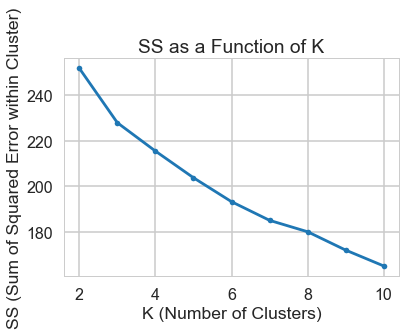

In [7]:
ks = np.arange(2,11,1)
inertias=[]

for k in ks:
    m1 = KMeans(n_clusters=k, random_state=10) # seed random_state of 10 for reproducibility
    m1.fit(matrix)
    inertias.append(m1.inertia_)

plt.plot(ks,inertias,marker='.');
plt.xlabel('K (Number of Clusters)');
plt.ylabel('SS (Sum of Squared Error within Cluster)');
plt.title('SS as a Function of K');

#### Exercise: Make a bar chart showing the number of points in each cluster for k-means under the best $K$

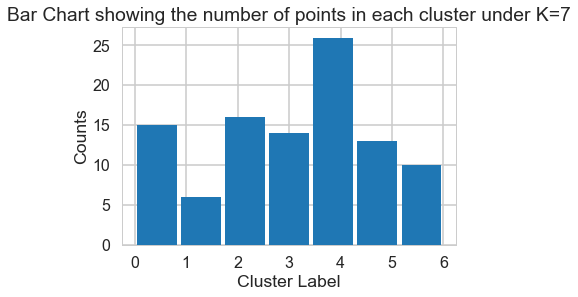

In [8]:
# choose k = 7 as the best K
m1 = KMeans(n_clusters=7, random_state=10) # seed random_state of 10 for reproducibility
labels_1 = m1.fit_predict(matrix)
# plot the bar chart 
plt.hist(labels_1,bins=7,rwidth=0.9);
plt.xticks(np.arange(7));
plt.xlabel('Cluster Label');
plt.ylabel('Counts');
plt.title('Bar Chart showing the number of points in each cluster under K=7');

#### Exercise: What challenges did you experience using the Elbow method to pick $K$?
As shown in the plot of $SS$ versus $K$, there is no clear 'Elbow' as $SS$ gradually decreass with increasing $K$. As a result, choosing  the best $K$ using $SS$ vs. $K$ plot becomes a bit arbitrary.

### Choosing K: The Silhouette Method

There exists another method that measures how well each datapoint $x_i$ "fits" its assigned cluster *and also* how poorly it fits into other clusters. This is a different way of looking at the same objective. Denote $a_{x_i}$ as the *average* distance from $x_i$ to all other points within its own cluster $k$. The lower the value, the better. On the other hand $b_{x_i}$ is the minimum average distance from $x_i$ to points in a different cluster, minimized over clusters. That is, compute separately for each cluster the average distance from $x_i$ to the points within that cluster, and then take the minimum. The silhouette $s(x_i)$ is defined as

$$s(x_i) = \frac{b_{x_i} - a_{x_i}}{\max{\left( a_{x_i}, b_{x_i}\right)}}$$

The silhouette score is computed on *every datapoint in every cluster*. The silhouette score ranges from -1 (a poor clustering) to +1 (a very dense clustering) with 0 denoting the situation where clusters overlap. Some criteria for the silhouette coefficient is provided in the table below.

<pre>

| Range       | Interpretation                                |
|-------------|-----------------------------------------------|
| 0.71 - 1.0  | A strong structure has been found.            |
| 0.51 - 0.7  | A reasonable structure has been found.        |
| 0.26 - 0.5  | The structure is weak and could be artificial.|
| < 0.25      | No substantial structure has been found.      |

</pre>
Source: http://www.stat.berkeley.edu/~spector/s133/Clus.html

Fortunately, scikit-learn provides a function to compute this for us (phew!) called [`sklearn.metrics.silhouette_score`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html). Take a look at [this article](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html) on picking $K$ in scikit-learn, as it will help you in the next exercise set.

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set III</h3>

<p><b>Exercise:</b> Using the documentation for the `silhouette_score` function above, construct a series of silhouette plots like the ones in the article linked above.</p>

<p><b>Exercise:</b> Compute the average silhouette score for each $K$ and plot it. What $K$ does the plot suggest we should choose? Does it differ from what we found using the Elbow method?</p>
</div>

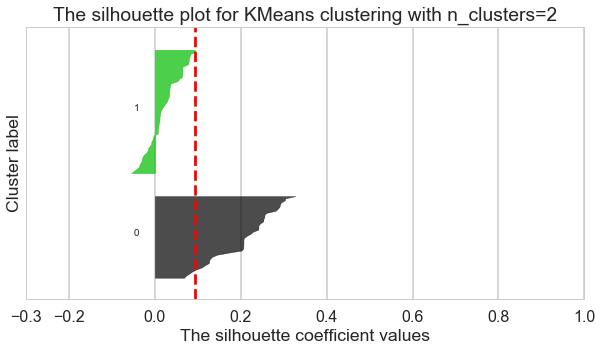

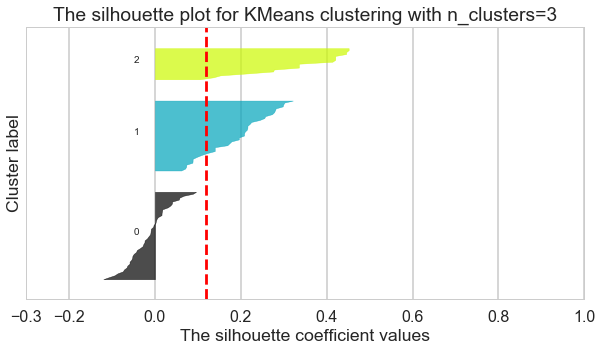

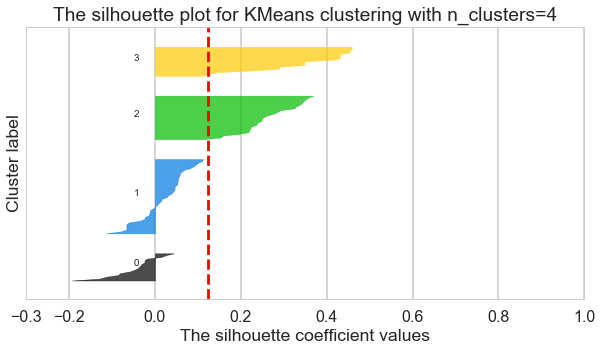

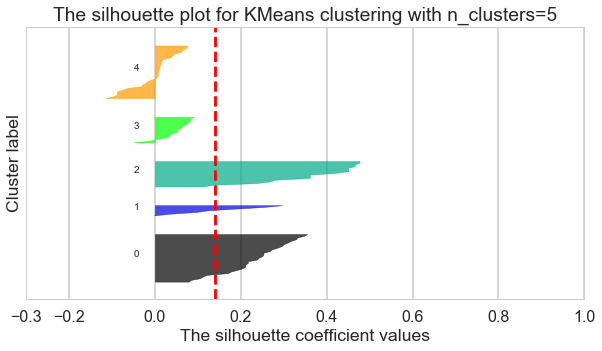

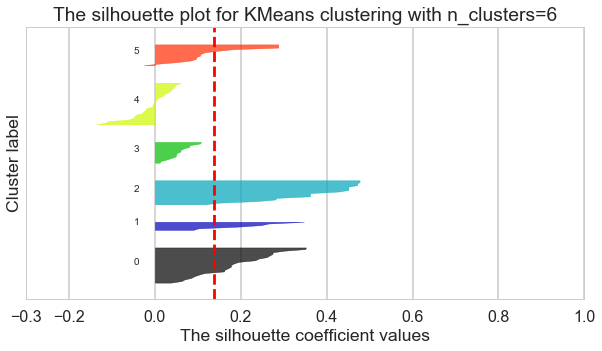

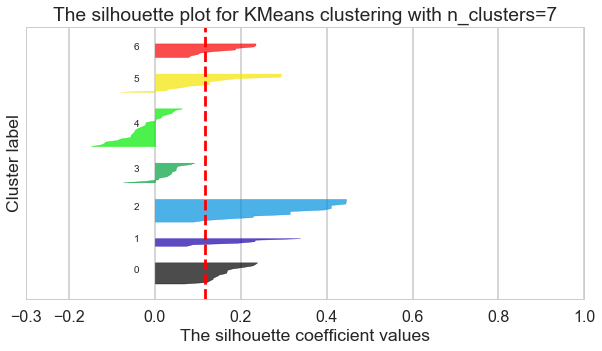

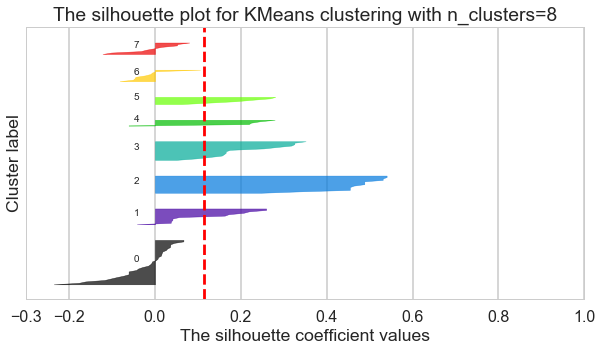

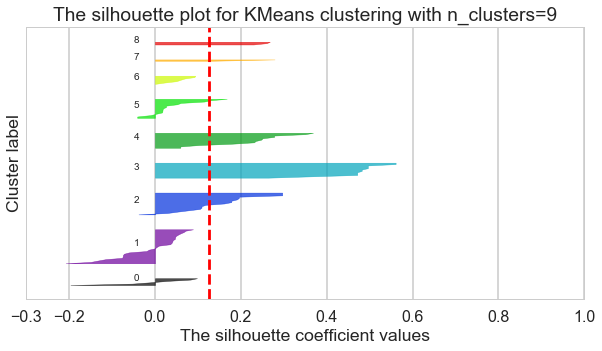

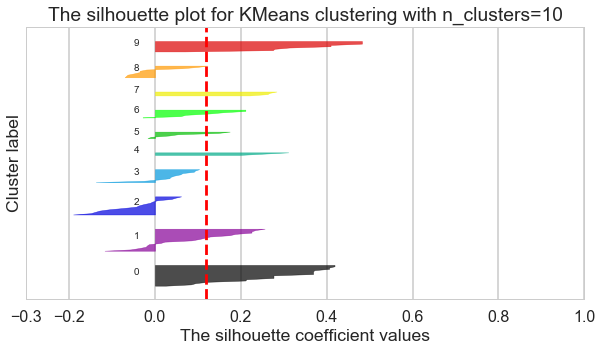

In [9]:
# Your turn.

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

ks = np.arange(2,11,1)
silhouette_scores = [] # initialize an empty list to record the average silhouette score for each K

# compute and create the silhouette plot for each K
for k in ks:
    fig, ax = plt.subplots()
    fig.set_size_inches(10, 5);

    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.3, 1]
    ax.set_xlim([-0.3, 1]);
    # The (k+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax.set_ylim([0, len(matrix) + (k + 1) * 10]);

    # Initialize the clusterer with k value and a random generator
    # seed random_state of 10 for reproducibility.
    m2 = KMeans(n_clusters=k, random_state=10)
    labels = m2.fit_predict(matrix)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed clusters
    silhouette_avg = silhouette_score(matrix, labels)
    silhouette_scores.append(silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(matrix, labels)

    y_lower = 10
    for i in range(k):
        # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / k)
        ax.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7);

        # Label the silhouette plots with their cluster numbers at the middle
        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i));

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax.set_title("The silhouette plot for KMeans clustering with n_clusters={}".format(k));
    ax.set_xlabel("The silhouette coefficient values");
    ax.set_ylabel("Cluster label");

    # The vertical line for average silhouette score of all the values
    ax.axvline(x=silhouette_avg, color="red", linestyle="--");

    ax.set_yticks([]);  # Clear the yaxis labels / ticks
    ax.set_xticks([-0.3, -0.2, 0, 0.2, 0.4, 0.6, 0.8, 1]);

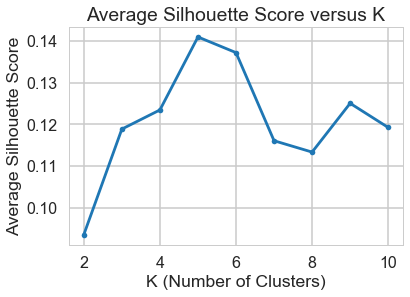

In [10]:
# plot average silhouette score as a function of K
plt.figure();
plt.plot(ks,silhouette_scores, marker='.');
plt.xlabel('K (Number of Clusters)');
plt.ylabel('Average Silhouette Score');
plt.title('Average Silhouette Score versus K');

The Silhouette method suggest a K value of 5 (number of clusters=5), as it has the higher Silhouette score among the number of clusters tested. This is different from the K=7 found using the Elbow method. But here the best K value is clear from the plot, whereas the best K value from the Elbow method is ambiguous. 

In [11]:
# perform KMeans clustering with the best K identified by Silhouette method, K=5
m2 = KMeans(n_clusters=5, random_state=10) # seed random_state of 10 for reproducibility
labels_2 = m2.fit_predict(matrix)

### Choosing $K$: The Gap Statistic

There is one last method worth covering for picking $K$, the so-called Gap statistic. The computation for the gap statistic builds on the sum-of-squares established in the Elbow method discussion, and compares it to the sum-of-squares of a "null distribution," that is, a random set of points with no clustering. The estimate for the optimal number of clusters $K$ is the value for which $\log{SS}$ falls the farthest below that of the reference distribution:

$$G_k = E_n^*\{\log SS_k\} - \log SS_k$$

In other words a good clustering yields a much larger difference between the reference distribution and the clustered data. The reference distribution is a Monte Carlo (randomization) procedure that constructs $B$ random distributions of points within the bounding box (limits) of the original data and then applies K-means to this synthetic distribution of data points.. $E_n^*\{\log SS_k\}$ is just the average $SS_k$ over all $B$ replicates. We then compute the standard deviation $\sigma_{SS}$ of the values of $SS_k$ computed from the $B$ replicates of the reference distribution and compute

$$s_k = \sqrt{1+1/B}\sigma_{SS}$$

Finally, we choose $K=k$ such that $G_k \geq G_{k+1} - s_{k+1}$.

### Aside: Choosing $K$ when we Have Labels

Unsupervised learning expects that we do not have the labels. In some situations, we may wish to cluster data that is labeled. Computing the optimal number of clusters is much easier if we have access to labels. There are several methods available. We will not go into the math or details since it is rare to have access to the labels, but we provide the names and references of these measures.

* Adjusted Rand Index
* Mutual Information
* V-Measure
* Fowlkes–Mallows index

See [this article](http://scikit-learn.org/stable/modules/clustering.html) for more information about these metrics.

## Visualizing Clusters using PCA

How do we visualize clusters? If we only had two features, we could likely plot the data as is. But we have 100 data points each containing 32 features (dimensions). Principal Component Analysis (PCA) will help us reduce the dimensionality of our data from 32 to something lower. For a visualization on the coordinate plane, we will use 2 dimensions. In this exercise, we're going to use it to transform our multi-dimensional dataset into a 2 dimensional dataset.

This is only one use of PCA for dimension reduction. We can also use PCA when we want to perform regression but we have a set of highly correlated variables. PCA untangles these correlations into a smaller number of features/predictors all of which are orthogonal (not correlated). PCA is also used to reduce a large set of variables into a much smaller one.

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set IV</h3>

<p><b>Exercise:</b> Use PCA to plot your clusters:</p>

<ul>
<li> Use scikit-learn's [`PCA`](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) function to reduce the dimensionality of your clustering data to 2 components
<li> Create a data frame with the following fields:
  <ul>
  <li> customer name
  <li> cluster id the customer belongs to
  <li> the two PCA components (label them `x` and `y`)
  </ul>
<li> Plot a scatterplot of the `x` vs `y` columns
<li> Color-code points differently based on cluster ID
<li> How do the clusters look? 
<li> Based on what you see, what seems to be the best value for $K$? Moreover, which method of choosing $K$ seems to have produced the optimal result visually?
</ul>

<p><b>Exercise:</b> Now look at both the original raw data about the offers and transactions and look at the fitted clusters. Tell a story about the clusters in context of the original data. For example, do the clusters correspond to wine variants or something else interesting?</p>
</div>

(100, 2)
(100, 5)


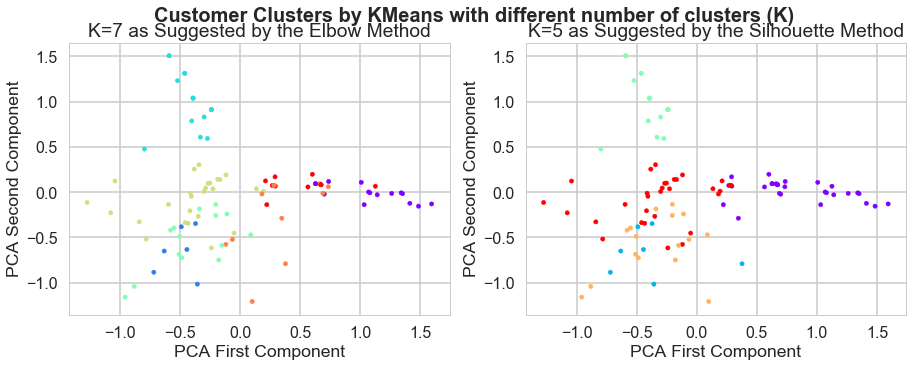

In [12]:
#your turn

# use scikit-learn's PCA function to reduce the dimensionality of your clustering data to 2 components
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca_features = pca.fit_transform(matrix)
print(pca_features.shape)

# create new DataFrame with four fields: customer name; cluster id; two PCA components labeled as x and y
customer_pca = pd.DataFrame({'custormer_name': matrix.index,'cluster_id_model1': labels_1,
                             'cluster_id_model2': labels_2, 'x': pca_features[:,0],'y': pca_features[:,1]})
print(customer_pca.shape)

# plot a scatterplot of the x vs y columns and color-code points differently based on cluster ID
fig, (ax1,ax2) = plt.subplots(1,2)
fig.set_size_inches(15, 5);
ax1.scatter(customer_pca.x, customer_pca.y, s=18, c=customer_pca.cluster_id_model1,cmap='rainbow');
ax1.set_xlabel('PCA First Component');
ax1.set_ylabel('PCA Second Component');
ax1.set_title('K=7 as Suggested by the Elbow Method');

ax2.scatter(customer_pca.x, customer_pca.y, s=18, c=customer_pca.cluster_id_model2,cmap='rainbow');
ax2.set_xlabel('PCA First Component');
ax2.set_ylabel('PCA Second Component');
ax2.set_title('K=5 as Suggested by the Silhouette Method');

plt.suptitle('Customer Clusters by KMeans with different number of clusters (K)', fontsize=20, fontweight='bold');

What we've done is we've taken those columns of 0/1 indicator variables, and we've transformed them into a 2-D dataset. We took one column and arbitrarily called it `x` and then called the other `y`. Now we can throw each point into a scatterplot. We color coded each point based on it's cluster so it's easier to see them.

#### Exercise: How do the clusters look? Based on what you see, what seems to be the best value for  $K$ ? Moreover, which method of choosing  $K$  seems to have produced the optimal result visually?

The plot with K=5 clusters looks better, therefore the Silhouette method seems to suggest a better K than the Elbow method in this case. 

#### Exercise: Now look at both the original raw data about the offers and transactions and look at the fitted clusters. Tell a story about the clusters in context of the original data. For example, do the clusters correspond to wine variants or something else interesting?

  customer_name  cluster  offer_id  n campaign   varietal  min_qty  discount  \
0         Adams        0        18  1     July  Espumante        6        50   

   origin  past_peak  
0  Oregon      False  


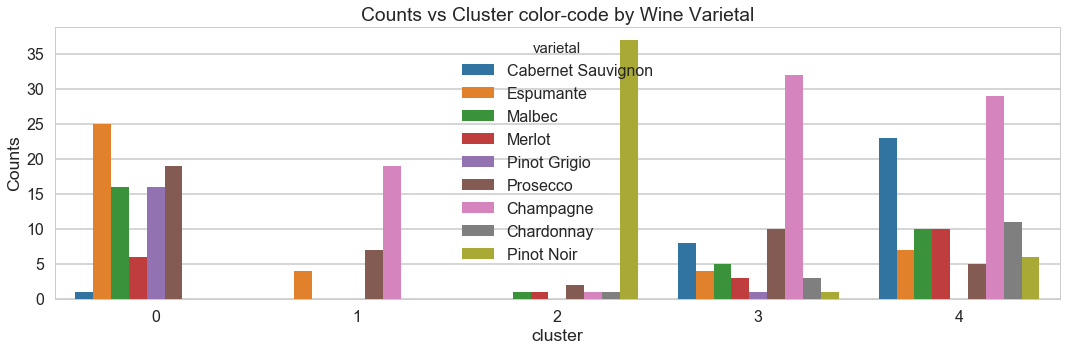

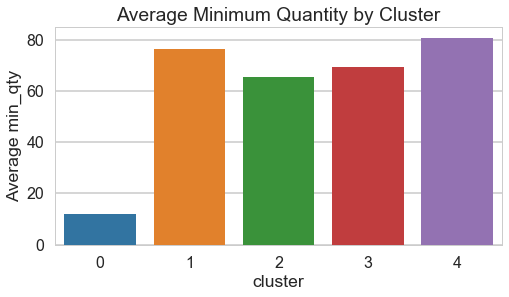

In [13]:
# merge all dataframes

matrix['cluster'] = labels_2  # add 'cluster' label to DataFrame matrix
# drop columns representing offers (i.e. the 0/1 colums) from DataFrame matrix and keep only the 'customer_name' and 'cluster' columns
df_cluster = matrix.reset_index()[['customer_name','cluster']] 
# merge df_cluster with df_merge, which is previously created by merging df_transactions and df_offers
df_merge_2 = pd.merge(df_cluster, df_merge, on='customer_name')
print(df_merge_2.head(1))

# relationship between 'cluster' and wine variants 'varietal'

# groupby 'cluster' and 'varietal'
cluster_varietal = df_merge_2.groupby(['cluster','varietal']).customer_name.count().reset_index()
# plot counts vs 'cluster' color-code by 'varietal'
fig = plt.figure(figsize=(18,5))
ax = fig.add_subplot()
ax = sns.barplot(x='cluster',y='customer_name', data=cluster_varietal, hue='varietal', ax=ax)
ax.set_ylabel('Counts');
ax.set_title('Counts vs Cluster color-code by Wine Varietal');

# relationship between 'cluster' and 'min_qty'

# groupby 'cluster', then take the mean of the 'min_qty' column
cluster_minqty = df_merge_2.groupby('cluster').min_qty.mean().reset_index()
# plot 'min_qty' by 'cluster'
fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot()
ax = sns.barplot(x='cluster',y='min_qty', data=cluster_minqty, ax=ax)
ax.set_ylabel('Average min_qty');
ax.set_title('Average Minimum Quantity by Cluster');

**As shown, customer clusters strongly correspond to the wine variants customers purchased:** 
cluster 0: favors Pinot Grigio, Espumante, Malbec and Prosecoo; On the other hand, no purchase history of Champagne, Chardonnay and Pinot Noir at all, also disfavors Cabernet Sauvignon; 
cluster 1: a strong preference of Champagne, followed by Prosecco and Espumante, whereas no purchase history of all other variants;
cluster 2: very strong preference of Pinot Noir, but minimal sampling of other flavors. Pinot Noir seems to be an easy sell to customers in this group;
cluster 3: strong preference of Champagne, followed by Prosecco and Cabernet Sauvignon; Minor sampling of other variants;
cluster 4: strong preference of Champagne and Cabernet Sauvignon with occational tasting of other variants except for Pinot Grigio;

**In addition, customer clusters are also related to the minimum required quantity:**
cluster 0: customers in this group tend to make purchases only when the minimum quantity is low, whereas customers in other groups tend to make purchases regardless of the minimum required quantity. 

**Correlations between cluster and other columns are also inspected, but no particular patterns are identified.**

<div class="span5 alert alert-info">
<h3>Exercise Set V</h3>

<p>As we saw earlier, PCA has a lot of other uses. Since we wanted to visualize our data in 2 dimensions, restricted the number of dimensions to 2 in PCA. But what is the true optimal number of dimensions?</p>

<p><b>Exercise:</b> Using a new PCA object shown in the next cell, plot the `explained_variance_` field and look for the elbow point, the point where the curve's rate of descent seems to slow sharply. This value is one possible value for the optimal number of dimensions. What is it?</p>
</div>

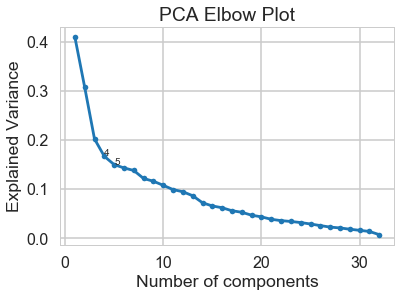

In [26]:
#your turn

# Initialize a new PCA model with a default number of components.
pca2 = PCA()
pca2.fit(matrix)

# Do the rest on your own :)
plt.plot(np.arange(1,(pca2.n_components_+1),1), pca2.explained_variance_, marker='.');
plt.xlabel('Number of components');
plt.ylabel('Explained Variance');
plt.title('PCA Elbow Plot');
plt.text(4,pca2.explained_variance_[3], '4');
plt.text(5,pca2.explained_variance_[4], '5');

Based on the PCA elbow plot, the rate of descent slows sharply around the 4th and 5th points. Therefore, the optimal number of dimensions can be either 4 or 5. 

## Other Clustering Algorithms

k-means is only one of a ton of clustering algorithms. Below is a brief description of several clustering algorithms, and the table provides references to the other clustering algorithms in scikit-learn. 

* **Affinity Propagation** does not require the number of clusters $K$ to be known in advance! AP uses a "message passing" paradigm to cluster points based on their similarity. 

* **Spectral Clustering** uses the eigenvalues of a similarity matrix to reduce the dimensionality of the data before clustering in a lower dimensional space. This is tangentially similar to what we did to visualize k-means clusters using PCA. The number of clusters must be known a priori.

* **Ward's Method** applies to hierarchical clustering. Hierarchical clustering algorithms take a set of data and successively divide the observations into more and more clusters at each layer of the hierarchy. Ward's method is used to determine when two clusters in the hierarchy should be combined into one. It is basically an extension of hierarchical clustering. Hierarchical clustering is *divisive*, that is, all observations are part of the same cluster at first, and at each successive iteration, the clusters are made smaller and smaller. With hierarchical clustering, a hierarchy is constructed, and there is not really the concept of "number of clusters." The number of clusters simply determines how low or how high in the hierarchy we reference and can be determined empirically or by looking at the [dendogram](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.cluster.hierarchy.dendrogram.html).

* **Agglomerative Clustering** is similar to hierarchical clustering but but is not divisive, it is *agglomerative*. That is, every observation is placed into its own cluster and at each iteration or level or the hierarchy, observations are merged into fewer and fewer clusters until convergence. Similar to hierarchical clustering, the constructed hierarchy contains all possible numbers of clusters and it is up to the analyst to pick the number by reviewing statistics or the dendogram.

* **DBSCAN** is based on point density rather than distance. It groups together points with many nearby neighbors. DBSCAN is one of the most cited algorithms in the literature. It does not require knowing the number of clusters a priori, but does require specifying the neighborhood size.

### Clustering Algorithms in Scikit-learn
<table border="1">
<colgroup>
<col width="15%" />
<col width="16%" />
<col width="20%" />
<col width="27%" />
<col width="22%" />
</colgroup>
<thead valign="bottom">
<tr><th>Method name</th>
<th>Parameters</th>
<th>Scalability</th>
<th>Use Case</th>
<th>Geometry (metric used)</th>
</tr>
</thead>
<tbody valign="top">
<tr><td>K-Means</span></a></td>
<td>number of clusters</td>
<td>Very large<span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span> with
MiniBatch code</td>
<td>General-purpose, even cluster size, flat geometry, not too many clusters</td>
<td>Distances between points</td>
</tr>
<tr><td>Affinity propagation</td>
<td>damping, sample preference</td>
<td>Not scalable with n_samples</td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Mean-shift</td>
<td>bandwidth</td>
<td>Not scalable with <span class="pre">n_samples</span></td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Distances between points</td>
</tr>
<tr><td>Spectral clustering</td>
<td>number of clusters</td>
<td>Medium <span class="pre">n_samples</span>, small <span class="pre">n_clusters</span></td>
<td>Few clusters, even cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Ward hierarchical clustering</td>
<td>number of clusters</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints</td>
<td>Distances between points</td>
</tr>
<tr><td>Agglomerative clustering</td>
<td>number of clusters, linkage type, distance</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints, non Euclidean
distances</td>
<td>Any pairwise distance</td>
</tr>
<tr><td>DBSCAN</td>
<td>neighborhood size</td>
<td>Very large <span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span></td>
<td>Non-flat geometry, uneven cluster sizes</td>
<td>Distances between nearest points</td>
</tr>
<tr><td>Gaussian mixtures</td>
<td>many</td>
<td>Not scalable</td>
<td>Flat geometry, good for density estimation</td>
<td>Mahalanobis distances to  centers</td>
</tr>
<tr><td>Birch</td>
<td>branching factor, threshold, optional global clusterer.</td>
<td>Large <span class="pre">n_clusters</span> and <span class="pre">n_samples</span></td>
<td>Large dataset, outlier removal, data reduction.</td>
<td>Euclidean distance between points</td>
</tr>
</tbody>
</table>
Source: http://scikit-learn.org/stable/modules/clustering.html

<div class="span5 alert alert-info">
<h3>Exercise Set VI</h3>

<p><b>Exercise:</b> Try clustering using the following algorithms. </p>
<ol>
<li>Affinity propagation
<li>Spectral clustering
<li>Agglomerative clustering
<li>DBSCAN
</ol>
<p>How do their results compare? Which performs the best? Tell a story why you think it performs the best.</p>
</div>


### Affinity propagation

In [15]:
matrix.drop('cluster',axis=1,inplace=True) # remove 'cluster' column from dataframe matrix

In [16]:
from sklearn.cluster import AffinityPropagation

# use default paramerter
m3 = AffinityPropagation()
labels_3 = m3.fit_predict(matrix)
score_3 = silhouette_score(matrix, labels_3, random_state=10) # seed random_state=10 for reproducibility

print('Sihouette score for AffinityPropagation clustering with default parameters is ', score_3)

Sihouette score for AffinityPropagation clustering with default parameters is  0.12346523604478911


In [17]:
# optimize parameters 

dampings = [0.5, 0.6, 0.7, 0.8, 0.9]
best_score_3 = -1
best_damping = None

for damping in dampings:
    m3 = AffinityPropagation(damping=damping)
    labels_3 = m3.fit_predict(matrix)
    score_3 = silhouette_score(matrix, labels_3, random_state=10) # seed random_state=10 for reproducibility
    print("For damping = {}, the average silhouette_score is {}".format(damping, score_3))
    if score_3 > best_score_3:
        best_score_3 = score_3
        best_damping = damping
        
print('Best damping parameter is {}, the corresponding best score is {}'.format(best_damping,best_score_3))

For damping = 0.5, the average silhouette_score is 0.12346523604478911
For damping = 0.6, the average silhouette_score is 0.12346523604478911
For damping = 0.7, the average silhouette_score is 0.12346523604478911
For damping = 0.8, the average silhouette_score is 0.08954554999885996
For damping = 0.9, the average silhouette_score is 0.08954554999885996
Best damping parameter is 0.5, the corresponding best score is 0.12346523604478911


### Spectral clustering

In [18]:
from sklearn.cluster import SpectralClustering

# use default paramerter
m4 = SpectralClustering()
labels_4 = m4.fit_predict(matrix)
score_4 = silhouette_score(matrix, labels_4, random_state=10) # seed random_state=10 for reproducibility

print('Sihouette score for SpectralClustering with default parameters is ', score_4)

Sihouette score for SpectralClustering with default parameters is  0.057245478221603904


In [19]:
# optimize parameters 

n_clusters = np.arange(2,11,1)
best_score_4 = -1
best_n_cluster = None

for n_cluster in n_clusters:
    m4 = SpectralClustering(n_clusters=n_cluster)
    labels_4 = m4.fit_predict(matrix)
    score_4 = silhouette_score(matrix, labels_4, random_state=10) # seed random_state=10 for reproducibility
    print("For n_clusters = {}, the average silhouette_score is {}".format(n_cluster, score_4))
    if score_4 > best_score_4:
        best_score_4 = score_4
        best_n_cluster = n_cluster
        
print('Best number of clusters is {}, the corresponding best score is {}'.format(best_n_cluster,best_score_4))

For n_clusters = 2, the average silhouette_score is 0.0591405970172056
For n_clusters = 3, the average silhouette_score is 0.09990591231024579
For n_clusters = 4, the average silhouette_score is 0.029065698932750638
For n_clusters = 5, the average silhouette_score is 0.02478686934619986
For n_clusters = 6, the average silhouette_score is 0.017596416995300394
For n_clusters = 7, the average silhouette_score is 0.046231912580754236
For n_clusters = 8, the average silhouette_score is 0.057245478221603904
For n_clusters = 9, the average silhouette_score is 0.042484087452151986
For n_clusters = 10, the average silhouette_score is 0.03670364873264992
Best number of clusters is 3, the corresponding best score is 0.09990591231024579


### Agglomerative clustering

In [20]:
from sklearn.cluster import AgglomerativeClustering

# use default paramerter
m5 = AgglomerativeClustering()
labels_5 = m5.fit_predict(matrix)
score_5 = silhouette_score(matrix, labels_5, random_state=10) # seed random_state=10 for reproducibility

print('Sihouette score for AgglomerativeClustering with default parameters is ', score_5)

Sihouette score for AgglomerativeClustering with default parameters is  0.08258017823184984


In [21]:
# optimize parameters 

n_clusters = np.arange(2,11,1)
linkages = ['ward', 'complete', 'average']
best_score_5 = -1
best_n_cluster = None
best_linkage = None

for n_cluster in n_clusters:
    for linkage in linkages:
        m5 = AgglomerativeClustering(n_clusters=n_cluster,linkage=linkage)
        labels_5 = m5.fit_predict(matrix)
        score_5 = silhouette_score(matrix, labels_5, random_state=10) # seed random_state=10 for reproducibility
        print("For n_clusters = {} and linkage={}, the average silhouette_score is {}".format(n_cluster, linkage, score_5))
        if score_5 > best_score_5:
            best_score_5 = score_5
            best_n_cluster = n_cluster
            best_linkage = linkage
        
print('Best number of clusters is {}, best linkage type is {}, the corresponding best score is {}'.format(best_n_cluster, best_linkage, best_score_5))

For n_clusters = 2 and linkage=ward, the average silhouette_score is 0.08258017823184984
For n_clusters = 2 and linkage=complete, the average silhouette_score is 0.2348896595208253
For n_clusters = 2 and linkage=average, the average silhouette_score is 0.2135580573835938
For n_clusters = 3 and linkage=ward, the average silhouette_score is 0.11625878863607858
For n_clusters = 3 and linkage=complete, the average silhouette_score is 0.0564209072156317
For n_clusters = 3 and linkage=average, the average silhouette_score is 0.18987407904100467
For n_clusters = 4 and linkage=ward, the average silhouette_score is 0.128937578158815
For n_clusters = 4 and linkage=complete, the average silhouette_score is 0.04965592388360875
For n_clusters = 4 and linkage=average, the average silhouette_score is 0.16084385829113018
For n_clusters = 5 and linkage=ward, the average silhouette_score is 0.14089739970831974
For n_clusters = 5 and linkage=complete, the average silhouette_score is 0.08118536531581164
F

### DBSCAN

In [22]:
from sklearn.cluster import DBSCAN

# use default paramerter
m6 = DBSCAN()
labels_6 = m6.fit_predict(matrix)
print(labels_6)
score_6 = silhouette_score(matrix, labels_6, random_state=10) # seed random_state=10 for reproducibility

print('Sihouette score for DBSCAN with default parameters is ', score_6)

[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1]


ValueError: Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)

In [23]:
# optimize parameters 

eps = np.arange(0.5, 11, 2)
min_samples = np.arange(1, 8, 1)
best_score_6 = -1
best_epsilon = None
best_min_sample = None

for epsilon in eps:
    for min_sample in min_samples:
        m6 = DBSCAN(eps=epsilon,min_samples=min_sample)
        labels_6 = m6.fit_predict(matrix)
        score_6 = silhouette_score(matrix, labels_6, random_state=10) # seed random_state=10 for reproducibility
        print("For eps = {} and min_samples={}, the average silhouette_score is {}".format(epsilon, min_sample, score_6))
        if score_6 > best_score_6:
            best_score_6 = score_6
            best_epsilon = epsilon
            best_min_sample = min_sample
        
print('Best eps is {}, best min_samples is {}, the corresponding best score is {}'.format(best_epsilon, best_min_sample, best_score_6))

For eps = 0.5 and min_samples=1, the average silhouette_score is 0.19
For eps = 0.5 and min_samples=2, the average silhouette_score is -0.021678059481408066
For eps = 0.5 and min_samples=3, the average silhouette_score is -0.10663555825496372


ValueError: Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)

**Summary:**
Among the four clusing models tested above, AgglomerativeClustering yields the highest Silhouette score. 
But even with AgglomerativeClustering, the best Sihouette score achieved is only 0.235, indicating that no substantial structure has been found (score <0.25), therefore none of the clustering methods is very successful at identifying the clear clustering pattern. This is probably because the clusterings characteristic is intrinsically weak in this case, as revealed by the visualization using two PCA components created above.